The data we use in this project is from [PhysioNet 2016 Challenge](https://physionet.org/content/challenge-2016/1.0.0/)

# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import librosa
import librosa.display
import IPython.display as ipd

from functions import *

import skimage.io
import wave


import tensorflow as tf
import tensorflow_io as tfio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions We Use

In [126]:
def print_results(model, X_train, y_train,X_test, y_test):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
        
        
    score = {}
    
    score["test_recall"]  = report["abnormal"]["TEST"]["recall"]
    score["train_recall"] = report["abnormal"]["TRAIN"]["recall"]
    
    score["test_precision"]  = report["abnormal"]["TEST"]["precision"]
    score["train_precision"] = report["abnormal"]["TRAIN"]["precision"]
    
    score["test_f1-score"]  = report["abnormal"]["TEST"]["f1-score"]
    score["train_f1-score"] = report["abnormal"]["TRAIN"]["f1-score"]
    
    score["test_accuracy"]  = report["accuracy"]["TEST"]["recall"]
    score["train_accuracy"] = report["accuracy"]["TRAIN"]["recall"]
    
    return report, score

# Train Set

In [3]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}
df_ref = {}

def file_path(audio_name):
    return f"../train_test_original/training-{audio_name[0]}/{audio_name}.wav"

for key in training:
    
    path = "../train_test_original/"+training[key]+"/REFERENCE-SQI.csv"
    df_ref[key] = pd.read_csv(path, header=None).rename(columns = {
       0:"name", 1:"num_1", 2:"num_2"})
    df_ref[key]["path"] = df_ref[key]["name"].apply(lambda x: file_path(x))

In [4]:
records = {}
df_records = {}


for key in training:
    
    all_rec = "../train_test_original/"+training[key]+"/RECORDS"
    normal  = "../train_test_original/"+training[key]+"/RECORDS-normal"
    abnormal= "../train_test_original/"+training[key]+"/RECORDS-abnormal"

    all_recs = {}
    normals = {}
    abnormals = {}

    with open(all_rec, "r") as rec:
        all_rec = rec.readlines()
        for line in all_rec:
            all_recs[line[:-1]] = 0


    with open(normal, "r") as n:
        n_recs = n.readlines()
        for line in n_recs:
            normals[line[:-1]] = "normal"
        
    with open(abnormal, "r") as ab:
        ab_recs = ab.readlines()
        for line in ab_recs:
            abnormals[line[:-1]] = "abnormal"     
        
        

    for item in all_recs:
        if item in list(normals.keys()):
            all_recs[item] = normals[item]
        else:
            all_recs[item] = abnormals[item]
            
    records[key] = all_recs
    df_records[key] = pd.DataFrame(list(records[key].items()),
                            columns = ['Audio','target'])

In [5]:
sum = 0
for item in df_records:
    print(item, len(df_records[item]))
    sum += len(df_records[item])
    
print("\n",sum)   

a 409
b 490
c 31
d 55
e 2141
f 114

 3240


In [6]:
df_train = pd.DataFrame()
all_records = pd.DataFrame()
all_ref = pd.DataFrame()

all_records = df_records["a"]
all_ref     = df_ref["a"]

for item in ["b", "c", "d", "e", "f"]:
    all_records = pd.concat([all_records, df_records[item]], axis = 0)
    all_ref     = pd.concat([all_ref, df_ref[item]], axis = 0)

df_train = pd.concat([all_ref, all_records], axis = 1)
df_train.drop(columns = ["num_1","Audio"], inplace = True, axis = 1)
# df_train = df_train.sample(frac = 1)


df_train.to_csv('df_train.csv')

In [7]:
df_train.head()

,name,num_2,path,target
0,a0001,1,../train_test_original/training-a/a0001.wav,abnormal
1,a0002,1,../train_test_original/training-a/a0002.wav,abnormal
2,a0003,1,../train_test_original/training-a/a0003.wav,abnormal
3,a0004,1,../train_test_original/training-a/a0004.wav,abnormal
4,a0005,1,../train_test_original/training-a/a0005.wav,abnormal


In [26]:
print("Duplications:\n")
print( df_train.duplicated().sum())
print("\nMissing Values:\n")
print(df_train.isna().sum())
print("\nTarget Values:\n")
print( df_train.target.value_counts(normalize = True))

Duplications:

0

Missing Values:

name      0
num_2     0
path      0
target    0
dtype: int64

Target Values:

normal      0.794753
abnormal    0.205247
Name: target, dtype: float64


# Test Set

This code is from [here](https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb) 

In [31]:
def get_wave(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)  ## The output needs to be decoded by using the next line
    ## Next line gives a numerical values of an audio file and the output needs to be reshaped
    # Decode wav (tensors by channels) ## Desired Channel = 1 means not sterio type
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) 
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

(570656,)


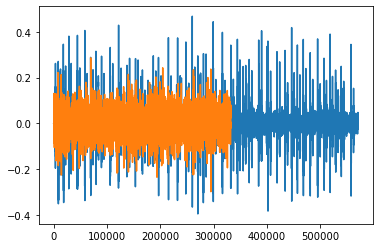

In [32]:
normal_path = df_train["path"].iloc[6]
normal_wav = get_wave(normal_path)

abnormal_path = df_train["path"].iloc[5]
abnormal_wav = get_wave(abnormal_path)


print(normal_wav.shape)
plt.plot(normal_wav)
plt.plot(abnormal_wav)
plt.show();

This code is from [here](https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb) 


Because the tensors will have different length, we will need to pad them with 0's. To do that we use the following function, this function is adopted from [here](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [28]:
def zero_padding(filename, input_len):
    waveform = get_wave(filename)
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([input_len] - tf.shape(waveform),
      dtype=tf.float32)
    
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    return equal_length
    

Getting the length of each audio file and add it to the df_train

In [14]:
# df_train["audio_length"] = df_train["path"].apply(lambda x: len(get_wave(x)))

In [15]:
# df_train["audio_length"].plot(kind = "hist");

In [33]:
# print("max: ", df_train["audio_length"].max())
# print("min: ", df_train["audio_length"].min())
# print("mean: ", df_train["audio_length"].mean())
# print("median: ", df_train["audio_length"].median())

# Getting Spectrogram of the Audio Files 

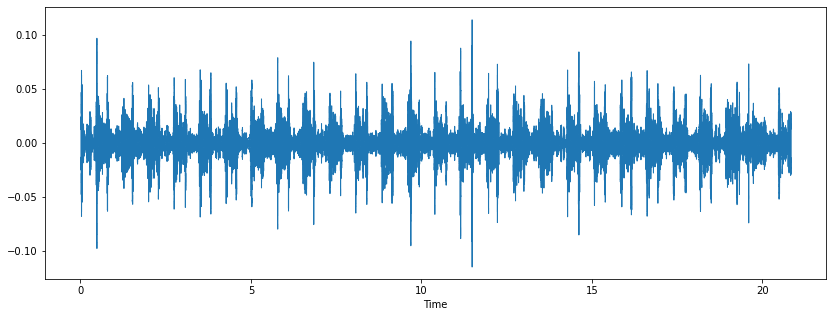

In [76]:
### Example
example_id = 1
audio_path = df_train["path"].iloc[example_id]
audio_name = df_train["name"].iloc[example_id]
fig_path = "../spectrograms/" +  audio_name

SAMPLE_RATE = 44000
x, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr);

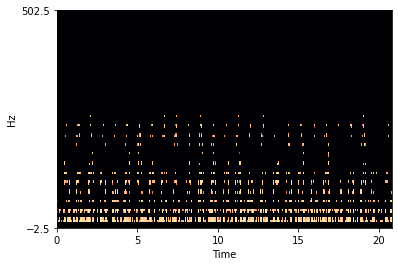

In [77]:
hl = 512 # number of samples per time-step in spectrogram
hi = 100 # Height of image
wi = 384 # Width of image
fmax = 500

S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=hi, fmax=fmax,
hop_length=hl)

S = np.log(S + 1e-10)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax)

plt.savefig(fig_path + ".png")
plt.show()

The following functions are from [here](https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349)

The next code is from [here](https://stackoverflow.com/questions/60255152/how-can-i-convert-spectrogram-data-to-a-tensor-or-multidimensional-numpy-array)